In [9]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import wandb
import random
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

In [3]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jaintarun (tarunwandb). Use `wandb login --relogin` to force relogin


True

In [4]:
train_dir = "../../../car_damage/training/"
validation_dir = "../../../car_damage/validation/"

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(224, 224), 
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


In [17]:
run = wandb.init(
    project="Joyride",
    config={
        "layer_1":256,
        "activation":"relu",
        "dropout":random.uniform(0.01,0.75),
        "layer_2":512,
        "optimizer":"adam",
        "loss":"binary_crossentropy",
        "metric":"accuracy",
        "output":"sigmoid",
        "epoch":3,
        "batch_size":64
    })

batch/accuracy,▆▁▆▆████
batch/batch_step,▁▂▃▄▅▆▇█
batch/learning_rate,▁▁▁▁▁▁▁▁
batch/loss,▁█▇▆▅▄▄▃
batch/accuracy,0.57083
batch/batch_step,35
batch/learning_rate,0.001
batch/loss,5.62266


In [18]:
config = wandb.config

In [19]:
from tensorflow.keras import Model 
from tensorflow.keras.applications import ResNet50   

base_model = ResNet50(input_shape = (224, 224, 3),  include_top = False, weights = 'imagenet') 

x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(config.layer_1, activation=config.activation)(x) 
x = tf.keras.layers.Dropout(config.dropout)(x)
x = tf.keras.layers.Dense(config.layer_2,activation=config.activation)(x)
x = tf.keras.layers.Dropout(config.dropout)(x)
x = tf.keras.layers.Dense(1, activation=config.output)(x) 

model= Model(base_model.input, x)

In [20]:
model.compile(optimizer=config.optimizer,loss=config.loss,metrics=[config.metric])

In [21]:
callback = [WandbMetricsLogger(log_freq=5),
            WandbModelCheckpoint("models")
           ]
history = model.fit(
      train_generator,
      epochs=config.epoch,
      batch_size=config.batch_size,
      validation_data=validation_generator,
      callbacks=callback)

Epoch 1/3
92/92 [==============================] - ETA: 0s - loss: 1.5864 - accuracy: 0.7245

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 15.5s


92/92 [==============================] - 495s 5s/step - loss: 1.5864 - accuracy: 0.7245 - val_loss: 0.6991 - val_accuracy: 0.5000
Epoch 2/3
92/92 [==============================] - ETA: 0s - loss: 0.6438 - accuracy: 0.8027

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 10.0s


92/92 [==============================] - 537s 6s/step - loss: 0.6438 - accuracy: 0.8027 - val_loss: 0.6954 - val_accuracy: 0.5000
Epoch 3/3
92/92 [==============================] - ETA: 0s - loss: 0.6703 - accuracy: 0.7913

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 30.1s


92/92 [==============================] - 556s 6s/step - loss: 0.6703 - accuracy: 0.7913 - val_loss: 2747.2615 - val_accuracy: 0.5000


In [8]:
model.save("classifier.h5")

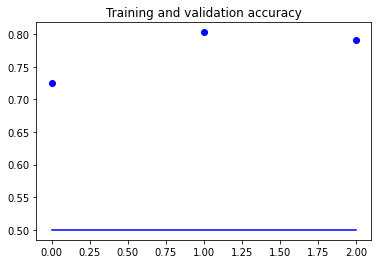

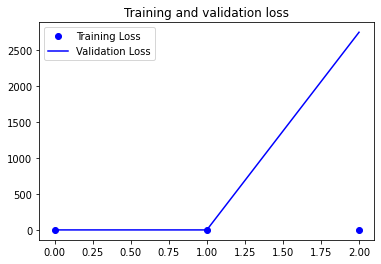

In [24]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()